# Actividad 4.3 Diagramas de voronoy
**Victor Misael Escalante Alvarado**

In [439]:

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import Voronoi
import scipy.spatial as spatial
import random
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from collections import defaultdict
from shapely.geometry import LineString, Polygon

## Funciones y codigo Previo

### Clases Usaddas para la triangulacion

In [440]:
# Clase para los puntos
class Punto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def show(self):
        return [self.x, self.y]
    
class PuntoConNombre:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

    def show(self):
        return [self.name, self.x, self.y]

# Clase para los segmentos
class Segmento:
    def __init__(self, A, B):
        self.A = A
        self.B = B

    def show(self):
        return [self.A.x, self.A.y, self.B.x, self.B.y]

# Clase para los triángulos
class Triangulo:
    def __init__(self, puntos):
        self.puntos = puntos
        self.circuncentro, self.circunradio = calcular_circuncentro_y_radio(*puntos)

        self.medios = []
        for i in range(3):
            self.medios.append(Punto((self.puntos[i].x + self.puntos[(i+1)%3].x)/2, (self.puntos[i].y + self.puntos[(i+1)%3].y)/2))

### Funciones de la tarea anterior

In [441]:
# Calcula circuncentro y circunradio
# Calcula circuncentro y radio
def calcular_circuncentro_y_radio(p1, p2, p3):
    ax, ay = p1.x, p1.y
    bx, by = p2.x, p2.y
    cx, cy = p3.x, p3.y
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    if d == 0:
        return None, None  # Los puntos son colineales
    ux = ((ax**2 + ay**2) * (by - cy) + (bx**2 + by**2) * (cy - ay) + (cx**2 + cy**2) * (ay - by)) / d
    uy = ((ax**2 + ay**2) * (cx - bx) + (bx**2 + by**2) * (ax - cx) + (cx**2 + cy**2) * (bx - ax)) / d
    
    circuncentro = Punto(ux, uy)
    
    radio = np.sqrt((ux - ax)**2 + (uy - ay)**2)
    
    return circuncentro, radio

# Verifica si un punto está dentro o sobre una circunferencia
def punto_dentro_circunferencia(punto, centro, radio):
    distancia = math.sqrt((centro.x - punto.x)**2 + (centro.y - punto.y)**2) # Distancia del punto al circuncentro
    return distancia <= radio  # Retorna True si está dentro del radio


def triangulacion_delaunay(puntos):
    triangulos = []
    for i in range(len(puntos)):
        for j in range(i + 1, len(puntos)):
            for k in range(j + 1, len(puntos)):
                p1, p2, p3 = puntos[i], puntos[j], puntos[k]
                centro, radio = calcular_circuncentro_y_radio(p1, p2, p3)
                if centro is None:
                    continue
                es_delaunay = all(math.sqrt((centro.x - p.x)**2 + (centro.y - p.y)**2) >= radio for p in puntos if p not in [p1, p2, p3])
                if es_delaunay:
                    triangulos.append(Triangulo([p1, p2, p3]))
    return triangulos



### Funciones para graficar

In [442]:
# Funcines para graficar
def graficar_triangulos_y_puntos(puntos, triangulos, deaths):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    for triangulo in triangulos:
        x_values = [punto.x for punto in triangulo.puntos] + [triangulo.puntos[0].x]
        y_values = [punto.y for punto in triangulo.puntos] + [triangulo.puntos[0].y]
        ax.plot(x_values, y_values, 'k-')

    for punto in puntos:
        ax.plot(punto.x, punto.y, 'bo')
        ax.text(punto.x, punto.y, punto.name, fontsize=12, ha='right')
    
    for death in deaths:
        ax.plot(death.x, death.y, 'ro')

    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    
    # Establecer límites de la gráfica
    ax.set_xlim(min(punto.x for punto in puntos) - 0.001, max(punto.x for punto in puntos) + 0.001)
    ax.set_ylim(min(punto.y for punto in puntos) - 0.001, max(punto.y for punto in puntos) + 0.001)
    plt.show()

### Funciones para cargar archivos

In [443]:
# Lectura de archivos
def cargar_puntos(archivo):
    puntos = []
    with open(archivo, 'r') as file:
        num_points = int(file.readline().strip())
        for line in file:
            x, y = map(float, line.strip().split())
            puntos.append(Punto(x, y))
    return puntos

def cargar_puntos_name(archivo):
    puntos = []
    with open(archivo, 'r') as file:
        # ignoarmoa la primera linea
        file.readline()
        for line in file:
            name, x, y = line.strip().split(',')
            puntos.append(PuntoConNombre(name, float(x), float(y)))
    return puntos

def cargar_deaths(archivo):
    puntos = []
    with open(archivo, 'r') as file:
        # ignoarmoa la primera linea
        file.readline()
        for line in file:
            name, x, y = line.strip().split(',')
            puntos.append(Punto(float(x), float(y)))
    return puntos

## Funciones y Codigo para el diagrama de voronoi

### Clases usadas

In [444]:
# Clase para los polígonos Voronoi
class PoligonoVoronoi:
    def __init__(self, puntos):
        # Los puntos que forman el polígono Voronoi
        self.puntos = puntos
    
    def show(self):
        # Muestra las coordenadas de los puntos del polígono
        return [(p.x, p.y) for p in self.puntos]

### Funciones nuevas partiendo de una triangulacion

**Tomada de la dualidad de la triangulacion de delaunay (incrementaal)**

In [ ]:
def vecinos_de_un_triangulo(triangulo, triangulos):
    vecinos = []
    for otro_triangulo in triangulos:
        if otro_triangulo == triangulo:
            continue
        puntos_en_comun = set(triangulo.puntos) & set(otro_triangulo.puntos)
        if len(puntos_en_comun) == 2:
            vecinos.append(otro_triangulo)
    return vecinos

def puntomedio_de_un_segmento(segmento):
    return Punto((segmento.A.x + segmento.B.x) / 2, (segmento.A.y + segmento.B.y) / 2)

def segmentos_voronoi(triangulos):
    segmentos_voronoi = []

    for triangulo in triangulos:
        vecinos = vecinos_de_un_triangulo(triangulo, triangulos)
        for vecino in vecinos:

            segmento = Segmento(triangulo.circuncentro, vecino.circuncentro)
            segmentos_voronoi.append(segmento)
            
    
    return segmentos_voronoi

def poligonos_voronoi(triangulos):
    poligonos_voronoi = []
    
    for triangulo in triangulos:
    
        puntos_poligono = [triangulo.circuncentro]
        
        # Agregar puntos medios de los lados del triángulo actual
        puntos_poligono.extend(triangulo.medios)
        
        # Crear el polígono y agregarlo a la lista
        poligono_voronoi = PoligonoVoronoi(puntos_poligono)
        poligonos_voronoi.append(poligono_voronoi)
    
    return poligonos_voronoi  # Asegúrate de que esta línea retorne la lista




**Mismo algoritmo de fortune pero con la libreria**

### grafica pero mas de cerca

In [446]:
def graficar_diagrama_voronoi(puntos_name,puntos_deaths,triangulos,segmentos, margen = 0.0025 ):

    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(figsize=(6, 8))

    # Dibujar puntos de la ciudad (excluyendo los puntos límite)
    for punto in puntos_name:
        ax.plot(punto.x, punto.y, 'bo')  # Puntos en azul
        

    #for punto in puntos_deaths:
        #ax.plot(punto.x, punto.y, 'ko')
    
    for triangulo in triangulos:
        ax.plot(triangulo.circuncentro.x,triangulo.circuncentro.y,"go")
        #for punto in triangulo.puntos:
            #ax.plot([triangulo.circuncentro.x, punto.x], [triangulo.circuncentro.y, punto.y], 'm--')
        #for medio in triangulo.medios:
            #ax.plot(medio.x, medio.y, 'yo')

    for triangulo in triangulos:
        x_values = [punto.x for punto in triangulo.puntos] + [triangulo.puntos[0].x]
        y_values = [punto.y for punto in triangulo.puntos] + [triangulo.puntos[0].y]
        ax.plot(x_values, y_values, 'k--')
    
    for segmento in segmentos:
        ax.plot([segmento.A.x, segmento.B.x], [segmento.A.y, segmento.B.y], 'r-')
    

    # Configurar ejes y mostrar el gráfico
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_aspect('equal', adjustable='box')
    # Establecer límites de la gráfica
    ax.set_xlim(min(triangulo.circuncentro.x for triangulo in triangulos) - margen, max(triangulo.circuncentro.x for triangulo in triangulos) + margen)
    ax.set_ylim(min(triangulo.circuncentro.y for triangulo in triangulos) - margen, max(triangulo.circuncentro.y for triangulo in triangulos) + margen)
    plt.show()


def graficar_poligonos_voronoi(puntos_name, puntos_deaths, triangulos, poligonos, margen=0.0025):
    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(figsize=(6, 8))

    # Dibujar puntos de la ciudad (excluyendo los puntos límite)
    for punto in puntos_name:
        ax.plot(punto.x, punto.y, 'bo')  # Puntos en azul

    # Dibujar puntos de deaths
    #for punto in puntos_deaths:
        #ax.plot(punto.x, punto.y, 'ko')  # Puntos en negro

    # Dibujar circuncentros y medios de los triángulos
    #for triangulo in triangulos:
        #ax.plot(triangulo.circuncentro.x, triangulo.circuncentro.y, "go")  # Circuncentro en verde
        #for medio in triangulo.medios:
            #ax.plot(medio.x, medio.y, 'yo')  # Puntos medios en amarillo

    # Dibujar bordes de los triángulos de Delaunay
    #for triangulo in triangulos:
        #x_values = [punto.x for punto in triangulo.puntos] + [triangulo.puntos[0].x]
        #y_values = [punto.y for punto in triangulo.puntos] + [triangulo.puntos[0].y]
        #ax.plot(x_values, y_values, 'k--')  # Bordes en negro discontinuo

    # Dibujar polígonos de Voronoi
    for i, poligono in enumerate(poligonos):
        x_values = [punto.x for punto in poligono.puntos] + [poligono.puntos[0].x]
        y_values = [punto.y for punto in poligono.puntos] + [poligono.puntos[0].y]
        ax.plot(x_values, y_values, color="m", linestyle='-', linewidth=1.5)

    # Configurar ejes y mostrar el gráfico
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_aspect('equal', adjustable='box')
    
    # Establecer límites de la gráfica con el margen
    ax.set_xlim(min(triangulo.circuncentro.x for triangulo in triangulos) - margen,
                max(triangulo.circuncentro.x for triangulo in triangulos) + margen)
    ax.set_ylim(min(triangulo.circuncentro.y for triangulo in triangulos) - margen,
                max(triangulo.circuncentro.y for triangulo in triangulos) + margen)
    
    plt.show()



### Codigo de la triangulacion y dagrama

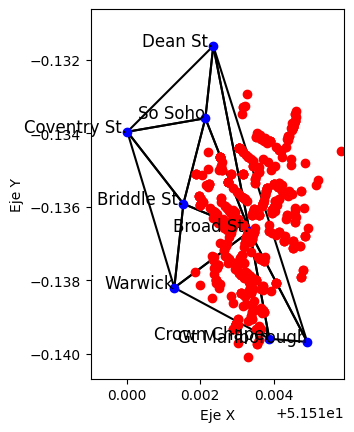

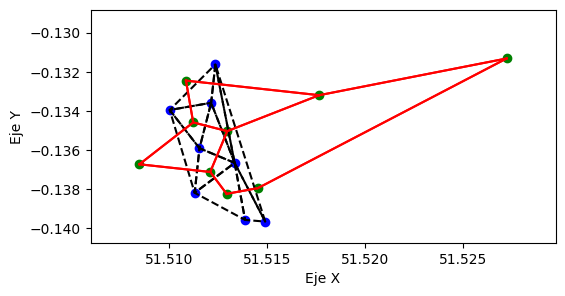

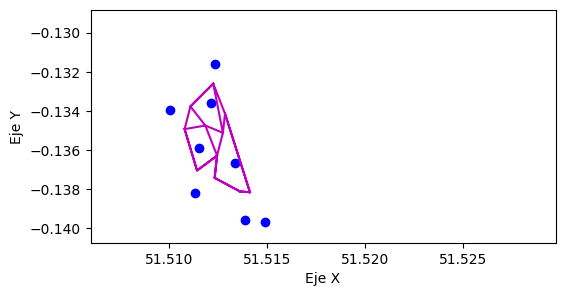

In [447]:

# ---- Inicio del código ---- #
# nombre del archivo
archivo_pumps = "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/Scripts/Python/pumps.csv"
archivo_deaths = "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/Scripts/Python/deaths.csv"



# Cargar puntos desde los archivos
puntos_name = cargar_puntos_name(archivo_pumps)
puntos_deaths = cargar_deaths(archivo_deaths)

# Inicializar los puntos para la triangulación
puntos = [Punto(punto.x, punto.y) for punto in puntos_name]

# Crear triangulación de Delaunay
triangulos = triangulacion_delaunay(puntos)

# Generar los segmentos y polígonos de Voronoi
segmentos = segmentos_voronoi(triangulos)
poligonos = poligonos_voronoi(triangulos)  # Asegúrate de almacenar los polígonos en una variable

graficar_triangulos_y_puntos(puntos_name, triangulos, puntos_deaths)
# Graficar el diagrama de Voronoi utilizando los segmentos y los polígonos
graficar_diagrama_voronoi(puntos_name, puntos_deaths, triangulos, segmentos)
graficar_poligonos_voronoi(puntos_name, puntos_deaths, triangulos, poligonos)  # Utiliza la variable poligonos
